# Deep Q Mountain Car
---
In this game, the agent is an underpowered car.\
It can't generate enough torque to get moving, but not climb the hill.\
The object is for the agent to learn to use both hills and momentum to reach the goal. 

### Pip Requirements
```
pip install gymnasium torch numpy
```

### Imports

In [12]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt

### Hyper Parameters

In [13]:
episodes = 25

capacity = 10000
sample_size = 8

learning_rate = .00001
discount_factor = 0.9
interpolation_parameter = 1e-3

epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay_rate = 1.2 / episodes

In [14]:
loss_hist = []
acc_hist = []

### Agents Environment

In [15]:
env = gym.make("MountainCar-v0", render_mode=None)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### Artifical Neural Network

In [16]:
class Network(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(Network, self).__init__()
        self.seed = seed
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

### Replay Memory

In [17]:
class Memory(object):
    def __init__(self, capacity):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, sample_size):
        experiences = random.sample(self.memory, sample_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        terminations = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return states, next_states, actions, rewards, terminations

### Agent

In [18]:
class Agent():
    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_network = Network(state_size, action_size).to(self.device)
        self.target_network = Network(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_network.parameters(), lr = learning_rate)
        self.acc = accuracy = MulticlassAccuracy(num_classes=3).to(self.device)
        self.memory = Memory(capacity)
        self.t_step = 0

    def step(self, state, action, reward, next_state, terminated):
        self.memory.push((state,action,reward,next_state,terminated))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.memory) > sample_size:
                experiences = self.memory.sample(sample_size)
                self.learn(experiences, discount_factor)

    def act(self, state, epsilon):
        st = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_network.eval()
        with torch.no_grad():
            action = self.local_network(st)
        self.local_network.train()
        if random.random() > epsilon:
            return np.argmax(action.cpu().data.numpy())
        else:
            if state[1] > 0:
                action = random.choices(np.arange(self.action_size),weights=(20,20,60))
            else:
                action = random.choices(np.arange(self.action_size),weights=(60,20,20))
            return action[0]

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, terminations = experiences
        next_q_targets = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + discount_factor * next_q_targets * (1 - terminations)
        q_expected = self.local_network(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_network, self.target_network, interpolation_parameter)

    def soft_update(self, local_model, target_model, interpolation_parameter):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

    def accuracy(self, e):
        X = self.local_network(torch.from_numpy(np.vstack([m[0] for m in agent.memory.memory if m is not None])).to(self.device))
        y = self.target_network(torch.from_numpy(np.vstack([m[3] for m in agent.memory.memory if m is not None])).to(self.device))
        actions = torch.from_numpy(np.vstack([m[1] for m in agent.memory.memory if m is not None])).to(self.device)
        t_acc = self.acc(X, torch.max(y, dim=1)[1])
        t_loss = F.mse_loss(X.gather(1, actions), y.detach().max(1)[0].unsqueeze(1))
        acc_hist.append(float(t_acc))
        loss_hist.append(float(t_loss))
        print(f'Episode: {e}\tLoss:{t_loss}\tAccuracy: {round(float(t_acc)*100)}%')

### Initiate Agent
Get its own cell to avoid re-initializing agent and dumping its memory

In [19]:
agent = Agent(state_size,action_size)

### Training The Agent
To see the un-trained agent, play the next cell first.

In [ ]:
epsilon = epsilon_start

for e in range(1, episodes+1):
    terminated = False
    state,_ = env.reset()
    score = 1000

    while(not terminated and score > 0):
        action = agent.act(state, epsilon)
        next_state, reward, terminated,truncated,_ = env.step(action)

        if terminated:
            reward = 10
        elif next_state[1] > 0:
            if next_state[0] < 0:
                reward = (next_state[0]*-1)*next_state[1]
        elif next_state[1] < 0 and next_state[0] < 0:
                reward = ((next_state[0]*1)*next_state[1])*0.1
        else:
            reward = reward - next_state[0]*next_state[1]
        agent.step(state, action, reward, next_state, terminated)
        state = next_state
        score += reward
    epsilon = max(0.05, epsilon - epsilon_decay_rate)
    if len(agent.memory.memory) > sample_size:
        agent.accuracy(e)
env.close()

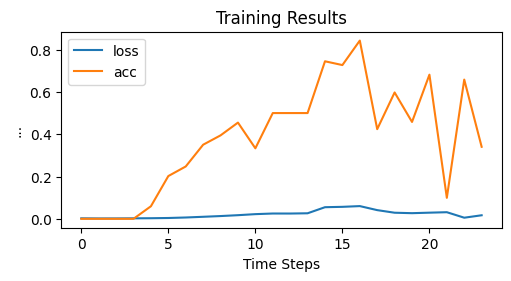

In [21]:
plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(loss_hist, label='loss')
plt.plot(acc_hist, label='acc')
plt.xlabel('Time Steps')
plt.ylabel('...')
plt.title("Training Results")
plt.legend()

### Test Agent And Visualize Results
All training and learning methods have been removed.\
Only a 10% of a weighted random event remain.

In [ ]:
env = gym.make("MountainCar-v0", render_mode='human')

for i in range(1,5):
    terminated = False
    state,_ = env.reset()
    score = 1000

    while(not terminated and score > 0):
        action = agent.act(state, .01)
        next_state, reward, terminated,_,_ = env.step(action)

        state = next_state
        score += reward
    print(f'Episode:{i}\tScore: {score}')
env.close()